In [1]:
from FLAI import data
from FLAI import causal_graph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas


2023-06-04 12:42:01.472500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 12:42:02.112895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-04 12:42:02.112988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-04 12:42:02.112994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
dataset_orig = load_preproc_data_compas()
df = pd.DataFrame(dataset_orig.features,columns = dataset_orig.feature_names)
df['label'] = dataset_orig.labels
df.to_pickle('../Data/compas.pickle')

In [3]:
dataset_orig.favorable_label

0.0

## Prepare Data

In [4]:
df = pd.read_pickle('../Data/compas.pickle')
df.head(5)

,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,label
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
df.shape

(5278, 11)

In [6]:
df.columns

Index(['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45',
       'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3',
       'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M',
       'label'],
      dtype='object')

In [7]:
df.label.describe()

count    5278.000000
mean        0.470443
std         0.499173
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [8]:
df['age'] = df.apply(lambda row: 0 if row['age_cat=Less than 25'] == 1 
                            else 1 if row['age_cat=25 to 45'] == 1 
                            else 2 if row['age_cat=Greater than 45'] == 1
                            else None,axis = 1)
df['priors'] = df.apply(lambda row: 0 if row['priors_count=0'] == 1 
                                  else 1 if row['priors_count=1 to 3'] == 1 
                                  else 2 if row['priors_count=More than 3'] == 1 
                                  else None,axis = 1)
df['charge_degree'] = df.apply(lambda row: 0 if row['c_charge_degree=F'] == 1 
                                  else 1 if row['c_charge_degree=M'] == 1 
                                  else None,axis = 1)
#### 1 is good 2 is bad in risk.
df['label'] = df.apply(lambda row: 0 if row['label'] == 1 
                            else 1 if row['label'] == 0 
                            else None,axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sex                       5278 non-null   float64
 1   race                      5278 non-null   float64
 2   age_cat=25 to 45          5278 non-null   float64
 3   age_cat=Greater than 45   5278 non-null   float64
 4   age_cat=Less than 25      5278 non-null   float64
 5   priors_count=0            5278 non-null   float64
 6   priors_count=1 to 3       5278 non-null   float64
 7   priors_count=More than 3  5278 non-null   float64
 8   c_charge_degree=F         5278 non-null   float64
 9   c_charge_degree=M         5278 non-null   float64
 10  label                     5278 non-null   int64  
 11  age                       5278 non-null   int64  
 12  priors                    5278 non-null   int64  
 13  charge_degree             5278 non-null   int64  
dtypes: float

In [10]:
df[['sex', 'race', 'age','priors','charge_degree' ,'label']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5278 non-null   float64
 1   race           5278 non-null   float64
 2   age            5278 non-null   int64  
 3   priors         5278 non-null   int64  
 4   charge_degree  5278 non-null   int64  
 5   label          5278 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 247.5 KB


In [11]:
flai_dataset = data.Data(df[['sex', 'race', 'age','priors' ,'label']], transform=True)


In [12]:
flai_dataset.data.head()

,sex,race,age,priors,label
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,2.0,0.0
2,0.0,1.0,1.0,2.0,0.0
3,1.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0


## Create Causal Graph

In [13]:
flai_graph = causal_graph.CausalGraph(flai_dataset, target = 'label')

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


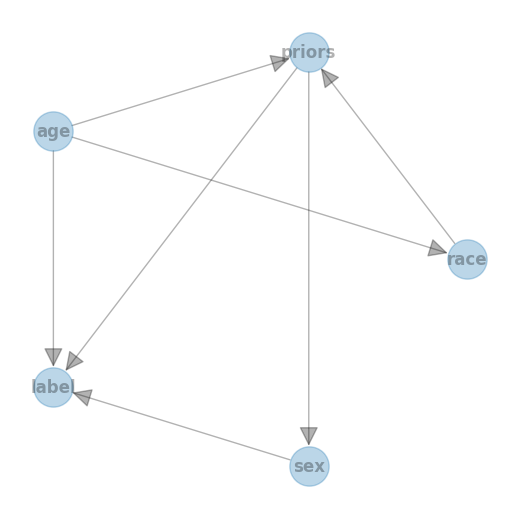

In [14]:
flai_graph.plot(directed = True)

In [15]:
flai_graph.calculate_cpd()

In [16]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'race': [60.16, 39.84],
 'priors': [31.58, 37.0, 31.41],
 'age': [21.9, 57.33, 20.77],
 'label': [46.94, 53.06],
 'sex': [80.47, 19.53]}

In [17]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.398273
1,0,1,0.406388
2,1,0,0.071097
3,1,1,0.124242


In [18]:
flai_graph.inference(variables=['race','label'], evidence={})

,race,label,p
0,0,0,0.306272
1,0,1,0.295281
2,1,0,0.163098
3,1,1,0.235348


In [19]:
flai_graph.inference(variables=['age','label'], evidence={})

,age,label,p
0,0,0,0.123802
1,0,1,0.095220
2,1,0,0.277017
3,1,1,0.296306
4,2,0,0.068551
5,2,1,0.139104


In [20]:
data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

100%|██████████| 36/36 [00:00<00:00, 812.65it/s]


In [22]:
result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.6667298219022357,
  'TN': 1395,
  'FP': 1088,
  'FN': 671,
  'TP': 2124,
  'TPR': 0.7599284436493738,
  'FPR': 0.4381796214256947,
  'FNR': 0.24007155635062613,
  'PPP': 0.6085638499431603},
 'sex': {'privileged': {'ACC': 0.6847720659553831,
   'TN': 107,
   'FP': 266,
   'FN': 59,
   'TP': 599,
   'TPR': 0.9103343465045592,
   'FPR': 0.7131367292225201,
   'FNR': 0.08966565349544073,
   'PPP': 0.8389912706110573},
  'unprivileged': {'ACC': 0.6623498940428538,
   'TN': 1288,
   'FP': 822,
   'FN': 612,
   'TP': 1525,
   'TPR': 0.7136172204024334,
   'FPR': 0.38957345971563984,
   'FNR': 0.2863827795975667,
   'PPP': 0.5526253826230281},
  'fair_metrics': {'EOD': -0.19671712610212588,
   'DI': 0.6586783462246727,
   'SPD': -0.2863658879880292,
   'OD': -0.5202803956090062}},
 'race': {'privileged': {'ACC': 0.6699952448882549,
   'TN': 336,
   'FP': 486,
   'FN': 208,
   'TP': 1073,
   'TPR': 0.8376268540202967,
   'FPR': 0.5912408759124088,
   'FNR': 0.16237314597970

In [23]:
df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)

In [24]:
df_performance

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.666730,1395.0,1088.0,671.0,2124.0,0.759928,0.438180,0.240072,0.608564
sex_privileged,0.684772,107.0,266.0,59.0,599.0,0.910334,0.713137,0.089666,0.838991
sex_unprivileged,0.662350,1288.0,822.0,612.0,1525.0,0.713617,0.389573,0.286383,0.552625
race_privileged,0.669995,336.0,486.0,208.0,1073.0,0.837627,0.591241,0.162373,0.741322
race_unprivileged,0.664567,1059.0,602.0,463.0,1051.0,0.694188,0.362432,0.305812,0.520630
age_privileged,0.666887,816.0,645.0,363.0,1202.0,0.768051,0.441478,0.231949,0.610377
age_unprivileged,0.634948,404.0,256.0,166.0,330.0,0.665323,0.387879,0.334677,0.506920


In [25]:
df_fairness

,EOD,DI,SPD,OD
sex_fair_metrics,-0.196717,0.658678,-0.286366,-0.520280
race_fair_metrics,-0.143439,0.702299,-0.220692,-0.372248
age_fair_metrics,-0.102729,0.830504,-0.103456,-0.156328


## Mitigate Causal Graph

In [26]:
flai_graph.mitigate_edge_relation(sensible_feature=['sex','race','age'])

[('race', 'priors'),
 ('priors', 'label'),
 ('age', 'priors'),
 ('age', 'label'),
 ('sex', 'label'),
 ('sex', 'priors'),
 ('race', 'label')]

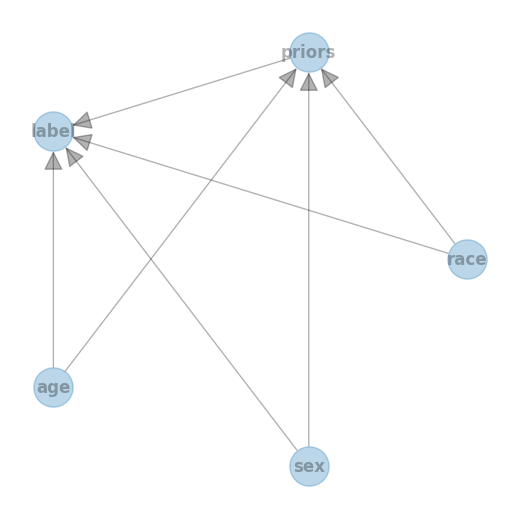

In [27]:
flai_graph.plot(directed = True)

In [28]:
flai_graph.mitigate_calculation_cpd(sensible_feature = ['sex','race','age'])


In [31]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'race': [50.0, 50.0],
 'priors': [31.58, 37.0, 31.41],
 'label': [47.04, 52.96],
 'age': [33.33, 33.33, 33.33],
 'sex': [50.0, 50.0]}

In [32]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.235222
1,0,1,0.264778
2,1,0,0.235222
3,1,1,0.264778


In [33]:
flai_graph.inference(variables=['race','label'], evidence={})

,race,label,p
0,0,0,0.235222
1,0,1,0.264778
2,1,0,0.235222
3,1,1,0.264778


In [34]:
flai_graph.inference(variables=['age','label'], evidence={})

,age,label,p
0,0,0,0.156814
1,0,1,0.176519
2,1,0,0.156814
3,1,1,0.176519
4,2,0,0.156814
5,2,1,0.176519


In [35]:
data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

100%|██████████| 36/36 [00:00<00:00, 942.90it/s]


In [36]:
result_metrics_mitigated = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.6352785145888594,
  'TN': 1108,
  'FP': 1375,
  'FN': 550,
  'TP': 2245,
  'TPR': 0.8032200357781754,
  'FPR': 0.5537656061216271,
  'FNR': 0.1967799642218247,
  'PPP': 0.6858658582796514},
 'sex': {'privileged': {'ACC': 0.6799224054316197,
   'TN': 127,
   'FP': 246,
   'FN': 84,
   'TP': 574,
   'TPR': 0.8723404255319149,
   'FPR': 0.6595174262734584,
   'FNR': 0.1276595744680851,
   'PPP': 0.7953443258971872},
  'unprivileged': {'ACC': 0.6244407817282788,
   'TN': 981,
   'FP': 1129,
   'FN': 466,
   'TP': 1671,
   'TPR': 0.7819372952737482,
   'FPR': 0.5350710900473934,
   'FNR': 0.21806270472625175,
   'PPP': 0.6592889098186956},
  'fair_metrics': {'EOD': -0.09040313025816671,
   'DI': 0.8289352024671648,
   'SPD': -0.1360554160784916,
   'OD': -0.21484946648423175}},
 'race': {'privileged': {'ACC': 0.661436043747028,
   'TN': 277,
   'FP': 545,
   'FN': 167,
   'TP': 1114,
   'TPR': 0.8696330991412958,
   'FPR': 0.6630170316301703,
   'FNR': 0.1303669008587041

In [37]:
df_performance_mitigated,df_fairness_mitigated = flai_dataset.get_df_metrics(metrics_json=result_metrics_mitigated)

In [38]:
df_performance_mitigated

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.635279,1108.0,1375.0,550.0,2245.0,0.803220,0.553766,0.196780,0.685866
sex_privileged,0.679922,127.0,246.0,84.0,574.0,0.872340,0.659517,0.127660,0.795344
sex_unprivileged,0.624441,981.0,1129.0,466.0,1671.0,0.781937,0.535071,0.218063,0.659289
race_privileged,0.661436,277.0,545.0,167.0,1114.0,0.869633,0.663017,0.130367,0.788873
race_unprivileged,0.617953,831.0,830.0,383.0,1131.0,0.747028,0.499699,0.252972,0.617638
age_privileged,0.666887,816.0,645.0,363.0,1202.0,0.768051,0.441478,0.231949,0.610377
age_unprivileged,0.495675,97.0,563.0,20.0,476.0,0.959677,0.853030,0.040323,0.898789


In [39]:
df_fairness_mitigated

,EOD,DI,SPD,OD
sex_fair_metrics,-0.090403,0.828935,-0.136055,-0.214849
race_fair_metrics,-0.122605,0.782937,-0.171235,-0.285923
age_fair_metrics,0.191626,1.472515,0.288412,0.603178


In [40]:
fair_data = flai_graph.generate_dataset(n_samples = 600*len(flai_dataset.data), methodtype = 'bayes')

            race    priors     label       age       sex
race    1.000000 -0.000935 -0.000294 -0.000398 -0.000025
priors -0.000935  1.000000 -0.293286  0.000195 -0.000402
label  -0.000294 -0.293286  1.000000 -0.000200  0.000664
age    -0.000398  0.000195 -0.000200  1.000000 -0.000888
sex    -0.000025 -0.000402  0.000664 -0.000888  1.000000


<AxesSubplot: >

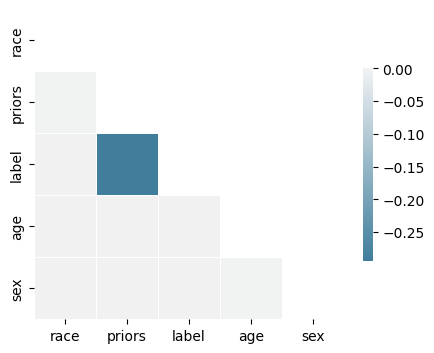

In [41]:
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = fair_data.data.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
data_pred = fair_data.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
fair_data.data['Predicted'] = out.label

100%|██████████| 36/36 [00:01<00:00, 28.88it/s]


In [43]:
result_metrics_mitigated_fair_data = fair_data.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated_fair_data

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.6353596690665656,
  'TN': 664491,
  'FP': 824318,
  'FN': 330425,
  'TP': 1347566,
  'TPR': 0.8030829724354899,
  'FPR': 0.5536761263533468,
  'FNR': 0.19691702756451018,
  'PPP': 0.6858292282430214},
 'sex': {'privileged': {'ACC': 0.6355803060281702,
   'TN': 332152,
   'FP': 411751,
   'FN': 165289,
   'TP': 674257,
   'TPR': 0.803120972525627,
   'FPR': 0.5535009268681536,
   'FNR': 0.19687902747437305,
   'PPP': 0.6858496863492288},
  'unprivileged': {'ACC': 0.6351390184488468,
   'TN': 332339,
   'FP': 412567,
   'FN': 165136,
   'TP': 673309,
   'TPR': 0.803044922445718,
   'FPR': 0.5538510899361798,
   'FNR': 0.19695507755428204,
   'PPP': 0.685808768870579},
  'fair_metrics': {'EOD': -7.605007990896251e-05,
   'DI': 0.9999403404572981,
   'SPD': -4.0917478649871164e-05,
   'OD': 0.0002741129881173032}},
 'race': {'privileged': {'ACC': 0.6349718162898621,
   'TN': 331665,
   'FP': 412453,
   'FN': 165130,
   'TP': 673049,
   'TPR': 0.8029895762122411,
   'FPR

In [44]:
df_performance_mitigated_fair_data, df_fairness_mitigated_fair_data = fair_data.get_df_metrics(result_metrics_mitigated_fair_data)

In [45]:
df_performance_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.635360,664491.0,824318.0,330425.0,1347566.0,0.803083,0.553676,0.196917,0.685829
sex_privileged,0.635580,332152.0,411751.0,165289.0,674257.0,0.803121,0.553501,0.196879,0.685850
sex_unprivileged,0.635139,332339.0,412567.0,165136.0,673309.0,0.803045,0.553851,0.196955,0.685809
race_privileged,0.634972,331665.0,412453.0,165130.0,673049.0,0.802990,0.554284,0.197010,0.686029
race_unprivileged,0.635747,332826.0,411865.0,165295.0,674517.0,0.803176,0.553068,0.196824,0.685630
age_privileged,0.635352,221550.0,274721.0,110162.0,449059.0,0.803008,0.553571,0.196992,0.685728
age_unprivileged,0.635436,221403.0,274361.0,110201.0,448890.0,0.802893,0.553410,0.197107,0.685640


In [46]:
df_fairness_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,-0.000076,0.999940,-0.000041,0.000274
race_fair_metrics,0.000187,0.999417,-0.000400,-0.001029
age_fair_metrics,-0.000116,0.999873,-0.000087,-0.000276


## Train Algorithm

In [43]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [44]:
original_X = flai_dataset.data[['sex', 'race', 'age','priors','charge_degree' ]]
original_y = flai_dataset.data[['label']]
mitigated_X = fair_data.data[['sex', 'race', 'age','priors','charge_degree' ]]
mitigated_y = fair_data.data[['label']]


In [45]:
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(original_X, original_y, test_size=0.5, random_state=54)
mitigated_X_train, mitigated_X_test, mitigated_y_train, mitigated_y_test = train_test_split(mitigated_X, mitigated_y, test_size=0.5, random_state=54)


In [46]:
model_original = XGBClassifier()
model_original.fit(original_X_train, original_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [47]:
model_mitigated = XGBClassifier()
model_mitigated.fit(mitigated_X_train, mitigated_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [48]:
original_y_test['Predicted'] = model_original.predict(original_X_test)
mitigated_y_test['Predicted'] = model_mitigated.predict(mitigated_X_test)

In [49]:
original_X_test[['label', 'Predicted']] = original_y_test[['label', 'Predicted']]
mitigated_X_test[['label', 'Predicted']] = mitigated_y_test[['label', 'Predicted']]


In [50]:
original_dataset = data.Data(original_X_test, transform=False)
mitigated_dataset = data.Data(mitigated_X_test, transform=False)

In [51]:
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [52]:
df_performance_xgboost

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.666161,717.0,502.0,379.0,1041.0,0.733099,0.411813,0.266901,0.584691
sex_privileged,0.665399,76.0,113.0,63.0,274.0,0.813056,0.597884,0.186944,0.735741
sex_unprivileged,0.666351,641.0,389.0,316.0,767.0,0.708218,0.377670,0.291782,0.547089
race_privileged,0.676110,180.0,237.0,106.0,536.0,0.834891,0.568345,0.165109,0.729934
race_unprivileged,0.659494,537.0,265.0,273.0,505.0,0.649100,0.330424,0.350900,0.487342
age_privileged,0.673469,417.0,291.0,205.0,606.0,0.747226,0.411017,0.252774,0.590520
age_unprivileged,0.618887,222.0,114.0,112.0,145.0,0.564202,0.339286,0.435798,0.436762


In [53]:
df_fairness_xgboost

,EOD,DI,SPD,OD
sex_fair_metrics,-0.104838,0.743589,-0.188652,-0.325052
race_fair_metrics,-0.185791,0.667652,-0.242592,-0.423712
age_fair_metrics,-0.183023,0.739623,-0.153758,-0.254755


In [54]:
metrics_xgboost_mitigated_fair_data = mitigated_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost_mitigated_fair_data,df_fairness_xgboost_mitigated_fair_data = original_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [55]:
df_performance_xgboost_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.635846,332837.0,412012.0,164589.0,673962.0,0.803722,0.553148,0.196278,0.685849
sex_privileged,0.636322,166179.0,205439.0,82161.0,337031.0,0.804002,0.552823,0.195998,0.685968
sex_unprivileged,0.635371,166658.0,206573.0,82428.0,336931.0,0.803443,0.553472,0.196557,0.685732
race_privileged,0.635339,166572.0,206506.0,82384.0,336754.0,0.803444,0.553520,0.196556,0.685747
race_unprivileged,0.636354,166265.0,205506.0,82205.0,337208.0,0.804000,0.552776,0.196000,0.685952
age_privileged,0.636027,110501.0,137166.0,54778.0,224913.0,0.804148,0.553832,0.195852,0.686591
age_unprivileged,0.636457,111480.0,137439.0,54768.0,225018.0,0.804250,0.552143,0.195750,0.685556


In [56]:
df_fairness_xgboost_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,-0.000559,0.999656,-0.000236,0.000091
race_fair_metrics,0.000556,1.000298,0.000204,-0.000188
age_fair_metrics,0.000102,0.998494,-0.001034,-0.001587


In [57]:
original_y_test['Predicted'] = model_mitigated.predict(original_X_test[['sex', 'race', 'age','priors','charge_degree']])
original_X_test[['label', 'Predicted']] = original_y_test[['label', 'Predicted']]
original_dataset = data.Data(original_X_test, transform=False)
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'race' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [58]:
df_performance_xgboost

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.640394,550.0,669.0,280.0,1140.0,0.802817,0.548811,0.197183,0.685487
sex_privileged,0.686312,65.0,124.0,41.0,296.0,0.878338,0.656085,0.121662,0.798479
sex_unprivileged,0.628964,485.0,545.0,239.0,844.0,0.779317,0.529126,0.220683,0.657359
race_privileged,0.671388,147.0,270.0,78.0,564.0,0.878505,0.647482,0.121495,0.787535
race_unprivileged,0.619620,403.0,399.0,202.0,576.0,0.740360,0.497506,0.259640,0.617089
age_privileged,0.676103,403.0,305.0,187.0,624.0,0.769420,0.430791,0.230580,0.611587
age_unprivileged,0.499157,53.0,283.0,14.0,243.0,0.945525,0.842262,0.054475,0.887015


In [59]:
df_fairness_xgboost

,EOD,DI,SPD,OD
sex_fair_metrics,-0.099022,0.823264,-0.141120,-0.225980
race_fair_metrics,-0.138145,0.783569,-0.170447,-0.288121
age_fair_metrics,0.176105,1.450351,0.275429,0.587576


### Explain Results

In [63]:
import shap

In [64]:
explainer_original = shap.Explainer(model_original)
explainer_mitigated = shap.Explainer(model_mitigated)

In [65]:
shap_values_orignal = explainer_original(original_dataset.data[['sex', 'race', 'age','priors','charge_degree']])
shap_values_mitigated = explainer_mitigated(original_dataset.data[['sex', 'race', 'age','priors','charge_degree']])

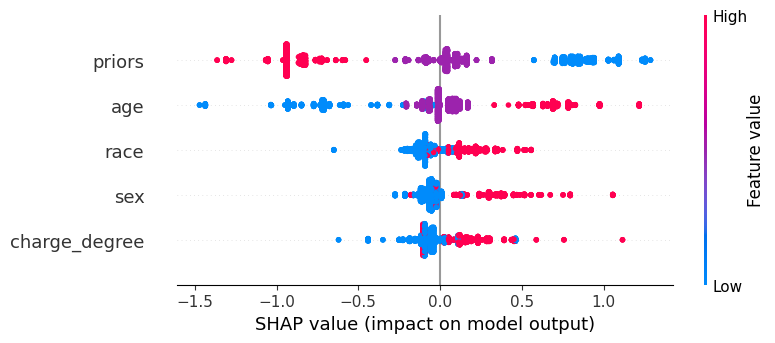

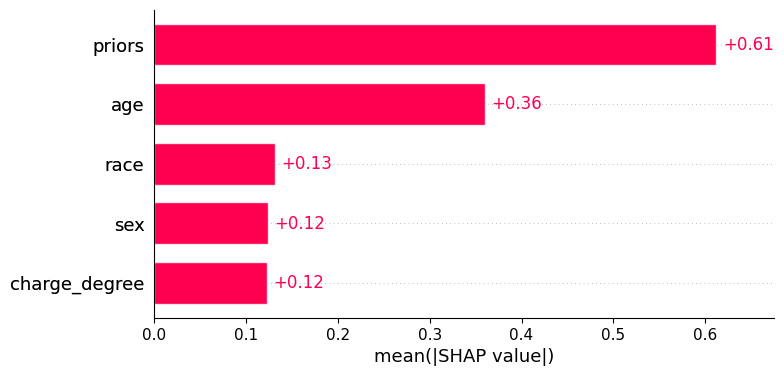

In [66]:
shap.plots.beeswarm(shap_values_orignal)
shap.plots.bar(shap_values_orignal)

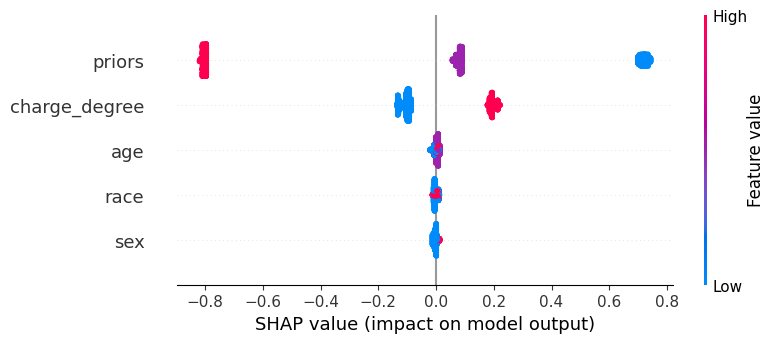

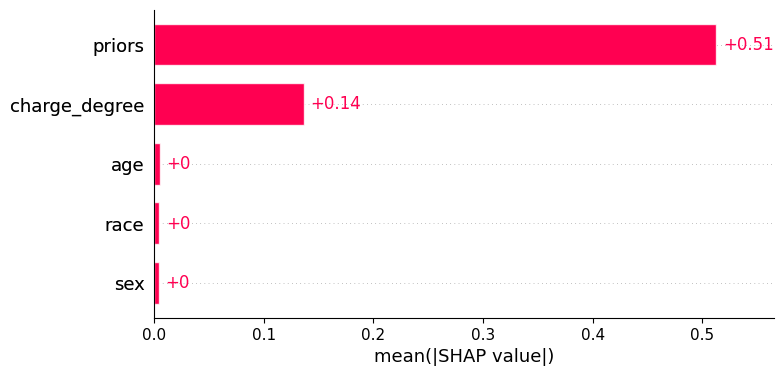

In [67]:
shap.plots.beeswarm(shap_values_mitigated)
shap.plots.bar(shap_values_mitigated)

In [68]:
shap_values_model_mitigated_dataset = explainer_original(mitigated_dataset.data[['sex', 'race', 'age','priors','charge_degree']])
shap_values_mitigated_dataset = explainer_mitigated(mitigated_dataset.data[['sex', 'race', 'age','priors','charge_degree']])

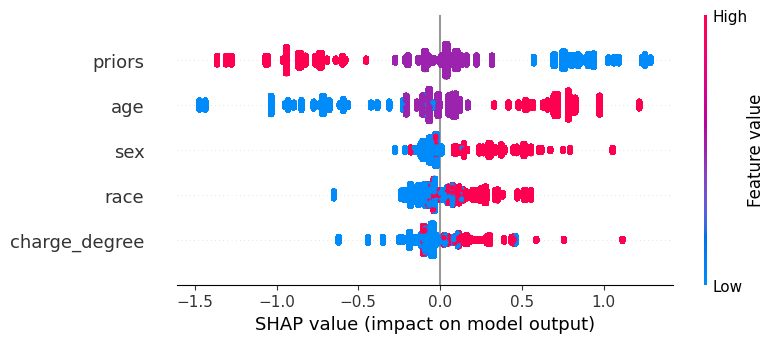

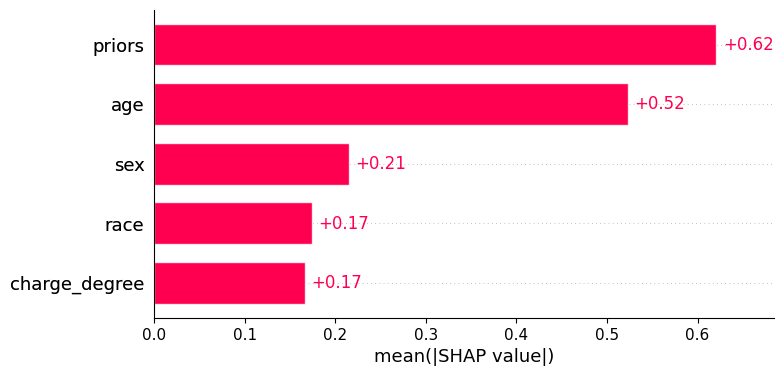

In [69]:
shap.plots.beeswarm(shap_values_model_mitigated_dataset)
shap.plots.bar(shap_values_model_mitigated_dataset)

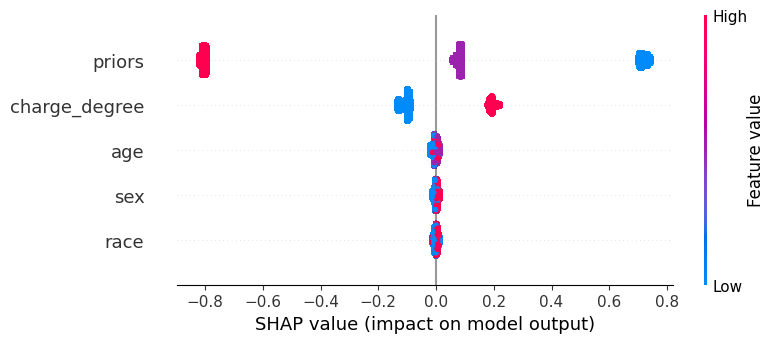

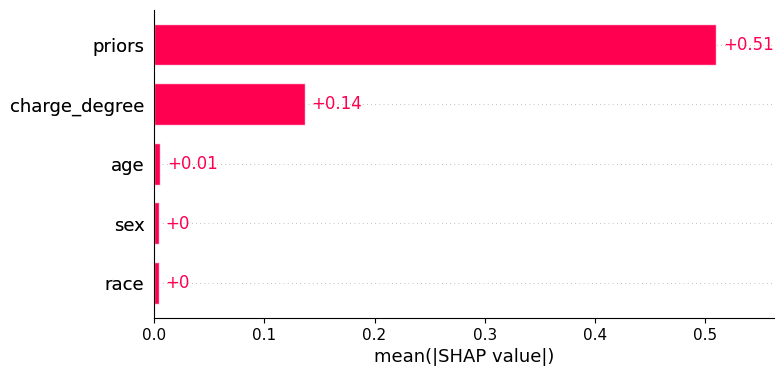

In [70]:
shap.plots.beeswarm(shap_values_mitigated_dataset)
shap.plots.bar(shap_values_mitigated_dataset)

### Test other algorithm

In [75]:
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_compas
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc


In [76]:
## import dataset
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

In [77]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [78]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [79]:
optim_options = {
    "distortion_fun": get_distortion_compas,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
OP = OptimPreproc(OptTools, optim_options)

OP = OP.fit(dataset_orig_train)
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

Optimized Preprocessing: Objective converged to 0.000000


                    sex      race       age    priors  charge_degree     label
sex            1.000000  0.069866 -0.010552 -0.130535       0.063881  0.042685
race           0.069866  1.000000  0.193305 -0.188126       0.108924  0.131079
age           -0.010552  0.193305  1.000000  0.151533       0.118670  0.170013
priors        -0.130535 -0.188126  0.151533  1.000000      -0.152194 -0.298223
charge_degree  0.063881  0.108924  0.118670 -0.152194       1.000000  0.127179
label          0.042685  0.131079  0.170013 -0.298223       0.127179  1.000000


<AxesSubplot: >

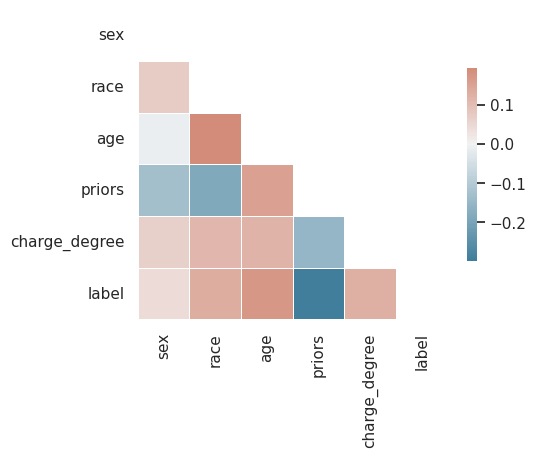

In [81]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_transf_train.features,columns = dataset_transf_train.feature_names)

df_train_transf['label'] = dataset_transf_train.labels
df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['age_cat=Less than 25'] == 1 
                            else 1 if row['age_cat=25 to 45'] == 1 
                            else 2 if row['age_cat=Greater than 45'] == 1
                            else None,axis = 1)
df_train_transf['priors'] = df_train_transf.apply(lambda row: 0 if row['priors_count=0'] == 1 
                                  else 1 if row['priors_count=1 to 3'] == 1 
                                  else 2 if row['priors_count=More than 3'] == 1 
                                  else None,axis = 1)
df_train_transf['charge_degree'] = df_train_transf.apply(lambda row: 0 if row['c_charge_degree=F'] == 1 
                                  else 1 if row['c_charge_degree=M'] == 1 
                                  else None,axis = 1)
#### 1 is good 2 is bad in risk.
df_train_transf['label'] = df_train_transf.apply(lambda row: 0 if row['label'] == 1 
                            else 1 if row['label'] == 0 
                            else None,axis = 1)
df_train_transf = df_train_transf[['sex', 'race', 'age','priors','charge_degree','label']]
# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [82]:
model_op = XGBClassifier()
model_op.fit( df_train_transf[['sex', 'race', 'age','priors','charge_degree']], df_train_transf['label'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [84]:
df_test = pd.DataFrame(dataset_orig_test.features,columns = dataset_orig_test.feature_names)

df_test['label'] = dataset_orig_test.labels
df_test['age'] = df_test.apply(lambda row: 0 if row['age_cat=Less than 25'] == 1 
                            else 1 if row['age_cat=25 to 45'] == 1 
                            else 2 if row['age_cat=Greater than 45'] == 1
                            else None,axis = 1)
df_test['priors'] = df_test.apply(lambda row: 0 if row['priors_count=0'] == 1 
                                  else 1 if row['priors_count=1 to 3'] == 1 
                                  else 2 if row['priors_count=More than 3'] == 1 
                                  else None,axis = 1)
df_test['charge_degree'] = df_test.apply(lambda row: 0 if row['c_charge_degree=F'] == 1 
                                  else 1 if row['c_charge_degree=M'] == 1 
                                  else None,axis = 1)
#### 1 is good 2 is bad in risk.
df_test['label'] = df_test.apply(lambda row: 0 if row['label'] == 1 
                            else 1 if row['label'] == 0 
                            else None,axis = 1)
df_test = df_test[['sex', 'race', 'age','priors','charge_degree','label']]

In [86]:
df_test['Predicted'] = model_op.predict(df_test[['sex', 'race', 'age','priors','charge_degree']])


In [87]:
op_dataset = data.Data(df_test, transform=False)

metrics_xgboost_mitigated_fair_data = op_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = op_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [88]:
df_performance_op

,ACC,TPR,FPR,FNR,PPP
model,0.648359,0.734355,0.435705,0.265645,0.583333
sex_privileged,0.647249,0.750000,0.530973,0.250000,0.669903
sex_unprivileged,0.648627,0.729131,0.420058,0.270869,0.562353
race_privileged,0.675591,0.834688,0.545113,0.165312,0.713386
race_unprivileged,0.630137,0.644928,0.381308,0.355072,0.496312


In [89]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,-0.020869,0.839454,-0.107550,-0.131784
race_fair_metrics,-0.189761,0.695713,-0.217074,-0.353565


In [90]:
explainer_op = shap.Explainer(model_op)


In [92]:
shap_values_op = explainer_op(df_test[['sex', 'race', 'age','priors','charge_degree']])


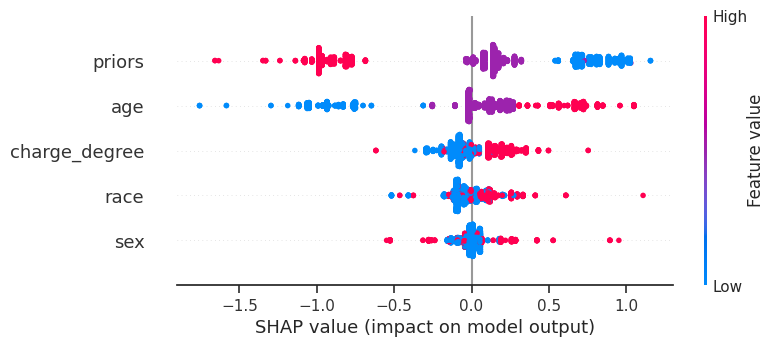

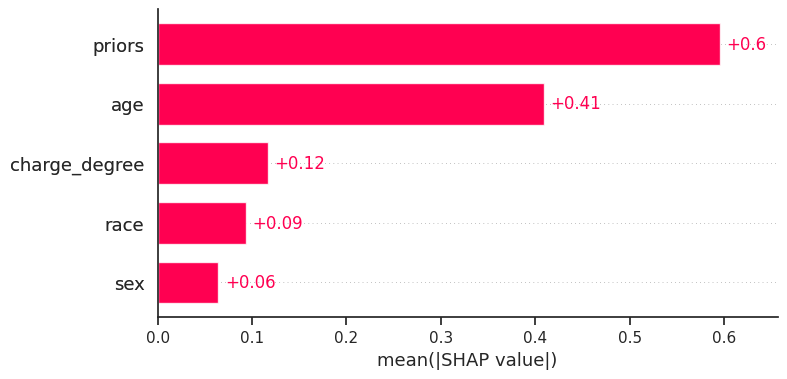

In [93]:
shap.plots.beeswarm(shap_values_op)
shap.plots.bar(shap_values_op)